### Prepare for dataset

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, to_date, when, count, sum
spark = SparkSession.builder.appName('housing_prices').getOrCreate()
housing_data = spark.read.csv('hdfs://namenode/full_housing_prices.csv', header = True, inferSchema = True)
housing_data.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bedroom2: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: integer (nullable = true)
 |-- BuildingArea: double (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



We can see that Date is being treated as a string. Since we want to compare the dates, we will cast it to the date type.

In [3]:
housing_data = housing_data.withColumn('Date', to_date(unix_timestamp(col('Date'), 'd/MM/yyyy').cast("timestamp")))
housing_data.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bedroom2: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: integer (nullable = true)
 |-- BuildingArea: double (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



### Data Exploration and Preprocessing
Since we are aiming to predict the price of the houses based on the housing data, we will drop rows where the price is unknown.

In [4]:
housing_data = housing_data.where(col("Price").isNotNull())

In [5]:
import pandas as pd
pd.DataFrame(housing_data.take(5), columns=housing_data.columns).transpose()

,0,1,2,3,4
Suburb,Abbotsford,Abbotsford,Abbotsford,Abbotsford,Abbotsford
Address,85 Turner St,25 Bloomburg St,5 Charles St,40 Federation La,55a Park St
Rooms,2,2,3,3,4
Type,h,h,h,h,h
Price,1480000,1035000,1465000,850000,1600000
Method,S,S,SP,PI,VB
SellerG,Biggin,Biggin,Biggin,Biggin,Nelson
Date,2016-12-03,2016-02-04,2017-03-04,2017-03-04,2016-06-04
Distance,2.5,2.5,2.5,2.5,2.5
Postcode,3067,3067,3067,3067,3067


In [6]:
numeric_features = [t[0] for t in housing_data.dtypes if t[1] == 'int']
housing_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Rooms,27247,2.9922927294748045,0.954795295019432,1,16
Price,27247,1050173.344955408,641467.1301045996,85000,11200000
Bedroom2,20806,3.0462366625012014,0.9551217965638036,0,20
Bathroom,20800,1.5916826923076923,0.7008803646354183,0,9
Car,20423,1.7153699260637516,0.9942160951843622,0,18
Landsize,17982,593.4889333778223,3757.266428643432,0,433014
YearBuilt,12084,1966.6091525984773,36.76237302581703,1196,2019


Correlations

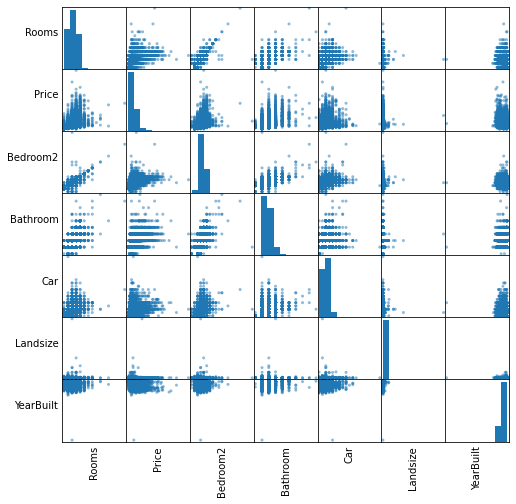

In [7]:
numeric_data = housing_data.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

We see that there Rooms and Bedroom2 may be highly correlated independent variables. So we can investigate them further.

In [8]:
correlated_data = housing_data.select(["Rooms", "Bedroom2"]).toPandas().dropna()
correlated_data["Rooms"].corr(correlated_data["Bedroom2"])

0.9587411322746887

We see that Rooms and Bedroom2 are highly correlated because the correlation value calculated is very close to 1. So we will drop Bedroom2.

In [9]:
housing_data = housing_data.drop("Bedroom2")
housing_data.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: integer (nullable = true)
 |-- BuildingArea: double (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



#### Working with missing data
We will first investigate the percentage of missing values in each column.

In [10]:
housing_data.select(*((sum(col(c).isNull().cast("int"))/housing_data.count()*100).alias(c) for c in housing_data.columns)).toPandas().transpose()

,0
Suburb,0.000000
Address,0.000000
Rooms,0.000000
Type,0.000000
Price,0.000000
Method,0.000000
SellerG,0.000000
Date,0.000000
Distance,0.000000
Postcode,0.000000


We can see that the BuildingArea and YearBuilt have a high percentage of null values and so we will drop them.

In [12]:
housing_data = housing_data.select([c for c in housing_data.columns if c not in ["BuildingArea", "YearBuilt"]])
housing_data.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: integer (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



We will fill in the missing values for Bathroom, Car and Landsize with the median values for each column.

In [67]:
from pyspark.sql.functions import mean
cols = ["Bathroom", "Car", "Landsize"]
median_data = [median[0] for median in housing_data.approxQuantile(cols, [0.5], 0)]
median_dict = dict(zip(cols, median_data))
    
print(median_dict)
housing_data = housing_data.fillna(median_dict)

{'Bathroom': 2.0, 'Car': 2.0, 'Landsize': 593.0}


In [53]:
housing_data.select(*((sum(col(c).isNull().cast("int"))/housing_data.count()*100).alias(c) for c in housing_data.columns)).toPandas().transpose()

,0
Suburb,0.000000
Address,0.000000
Rooms,0.000000
Type,0.000000
Price,0.000000
Method,0.000000
SellerG,0.000000
Date,0.000000
Distance,0.000000
Postcode,0.000000


### Dealing with Outliers
We will investigate how many values are in each price range.

In [57]:
numeric_features = [t[0] for t in housing_data.dtypes if t[1] == 'int']
bounds = {
    c: dict(
        zip(["q1", "q3"], housing_data.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in housing_data.select(numeric_features).columns
}
print(bounds)

{'Rooms': {'q1': 2.0, 'q3': 4.0}, 'Price': {'q1': 635000.0, 'q3': 1295000.0}, 'Bathroom': {'q1': 1.0, 'q3': 2.0}, 'Car': {'q1': 1.0, 'q3': 2.0}, 'Landsize': {'q1': 351.0, 'q3': 593.0}}
